Importing packages:

In [597]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn")
from skimage.io import imsave, imread

In [598]:
import os
os.chdir('F:/NRCan/data/PRAISE_Lithoprobe/')

Reading the seismic data - example:

In [599]:
example_segy = "L12.sgy"

with segyio.open(example_segy, ignore_geometry=True) as f:
    print("Bouguer Gravity:", (f.header[1000][189]))
    print("Isostatic:", (f.header[1000][193]))
    print("Magnetic Anomaly:", (f.header[1000][197]))
    print("Number of traces in the segy:", len(f.header))

Bouguer Gravity: -1035043319
Isostatic: -1053421968
Magnetic Anomaly: 1126065732
Number of traces in the segy: 9735


In [600]:
seismic_lines =  "L11a.sgy", "L11b.sgy", "L12.sgy", "L13(1).sgy"

"""
info from the header:

POTENTIAL FIELD DATA: BOUGUER GRAVITY: WORD 16 (SEGY 189)
ISOSTATIC: WORD 17 (SEGY 193)                .
MAGNETIC ANOM.: WORD 18 (SEGY 197) 

f.header[trace_number][header_field_number]))
"""

###### f.header[trace_number][header_field_number]))

segy_vals = {}
gravity_vals = []
isostatic_vals = []
magnetic_vals = []
cdp = []
sx = []
sy = []
line_nums = []

for fseis in seismic_lines:
    with segyio.open(fseis, ignore_geometry=True) as f:
        line_num = fseis[:-4]
        for i in range(len(f.header)):
            gravity_vals.append(f.header[i][189])
            cdp.append(f.header[i][21])
            isostatic_vals.append(f.header[i][193])
            line_nums.append(line_num)
            sx.append(f.header[i][73])
            sy.append(f.header[i][77])

import pandas as pd
df = pd.DataFrame({'Bouguer_anomaly':gravity_vals, 'isostatic':isostatic_vals, 'cdp':cdp,'sx':sx,'sy':sy,'line_num':line_nums})
df = df[df['Bouguer_anomaly']!=0]


In [601]:
df.line_num.unique()

array(['L11a', 'L11b', 'L12', 'L13(1)'], dtype=object)

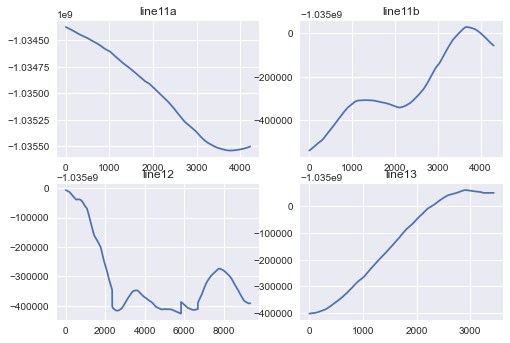

In [618]:
line11a_df = df[df['line_num']=='L11a']
line11b_df = df[df['line_num']=='L11b']
line12_df = df[df['line_num']=='L12']
line13_df = df[df['line_num']=='L13(1)']

plt.subplot(221)
plt.plot(line11a_df.cdp, line11a_df.Bouguer_anomaly)
plt.title('line11a')

plt.subplot(222)
plt.plot(line11b_df.cdp, line11b_df.Bouguer_anomaly)
plt.title('line11b')

plt.subplot(223)
plt.plot(line12_df.cdp, line12_df.Bouguer_anomaly)
plt.title('line12')

plt.subplot(224)
plt.plot(line13_df.cdp, line13_df.Bouguer_anomaly)
plt.title('line13')

plt.show;

Further manipulations as described in https://github.com/equinor/segyio-notebooks/blob/master/notebooks/basic/02_segy_quicklook.ipynb

In [619]:
import re

def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df

def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

In [620]:
with segyio.open(fseis, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    twt = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    # Load headers
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)
f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms'

'N Traces: 3640, N Samples: 4501, Sample rate: 4.0ms'

In [621]:
bin_headers

{JobID: 0, LineNumber: 0, ReelNumber: 1, Traces: 0, AuxTraces: 0, Interval: 4000, IntervalOriginal: 0, Samples: 4501, SamplesOriginal: 0, Format: 1, EnsembleFold: 0, SortingCode: 0, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 0, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 0, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}

In [622]:
text_headers

{'C01': 'ANOM.: WORD 18 (SEGY 197) .C21 .C22 .C23 .C24 .C25 .C26 .C27 .C28 .C29 .C30 .C31 .C32 .C33 .C34 .C35 .C36 .C37 .C38 .C39 .C40 END EBCDIC'}

Text(0.5, 1.0, 'L13(1).sgy')

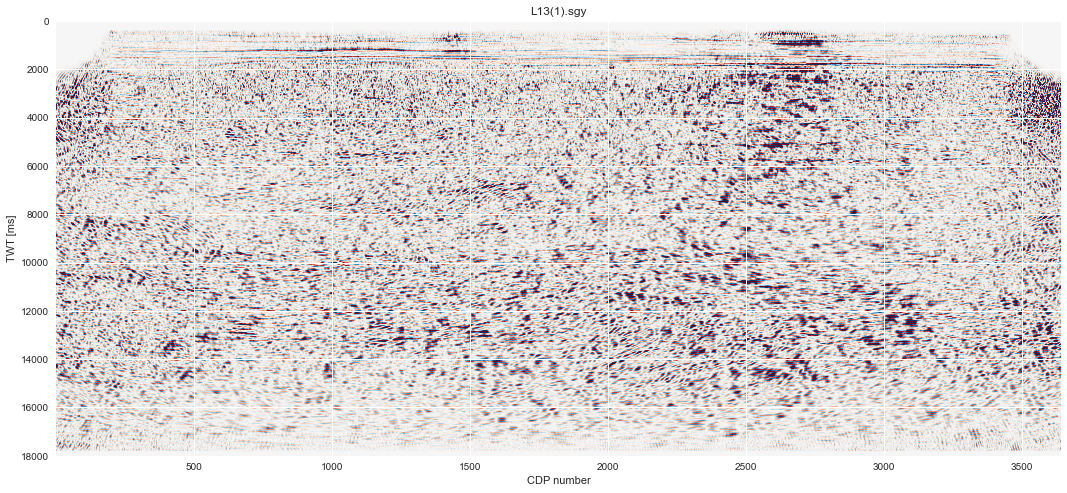

In [623]:
clip_percentile = 70
vm = np.percentile(data, clip_percentile)
f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}'

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [1, n_traces, twt[-1], twt[0]]  # define extent
ax.imshow(data.T, cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto', extent=extent)
ax.set_xlabel('CDP number')
ax.set_ylabel('TWT [ms]')
ax.set_title(f'{fseis}')


In [ ]:
import rasterio
import earthpy.plot as ep
from matplotlib import pyplot
src = rasterio.open('../Geophysics_GDR/geotif_grids_paletted_26910/Canada_GRAV_2km_Bouguer_GeoTIFF_clip_26910.tif') 

fig, ax = plt.subplots(figsize = (10, 5))
gravi = src.read()
pyplot.imshow(src.read(1), cmap='pink')


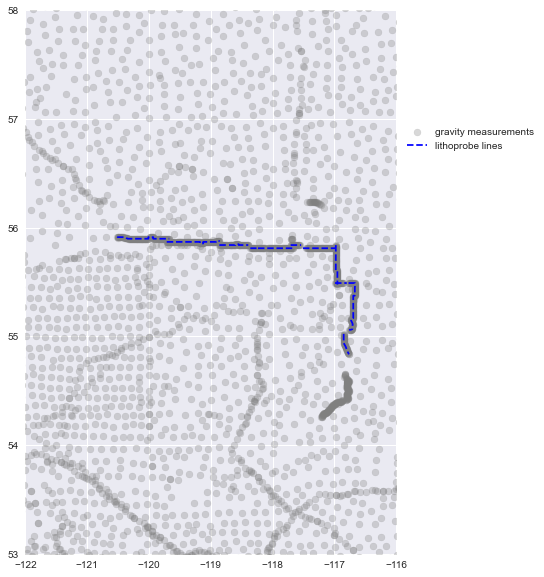

In [494]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set_xlim(-122, -116) 
ax.set_ylim(53, 58) 

gdf.plot(ax = ax, color='grey', alpha=0.3, label='gravity measurements')
lithoprobe.plot(ax = ax, linestyle='dashed', color='blue', label='lithoprobe lines')
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.8))
plt.show()

We can see that overlap with the lithoprobe lines

Convert gravi points to geodataframe and get the points intersecting with lithoprobe

In [448]:
litpoprobe_file = os.path.join("F:/","NRCan","shapefiles", "draft", "lithoprobe.geojson")
lithoprobe = gpd.read_file(litpoprobe_file)

gravi_df = pd.read_csv("../potential_data/gravi_NRCan/Gravity - CSV Point Data - CSV Données ponctuelles/Canada_Gravity_2018_test.csv", sep=",")
gdf = gpd.GeoDataFrame(
    gravi_df, geometry=gpd.points_from_xy(gravi_df.X, gravi_df.Y), crs=4326)

gdf_utm = gdf.to_crs(crs=32610) #  to have distance in meters
lithoprobe_utm = lithoprobe.to_crs(32610)

Some gravity measurements are no directly on the lithoprobe profile, so we create 10m buffer

In [ ]:
buffer = 10
lithoprobe_utm['geometry'] = lithoprobe_utm.geometry.buffer(buffer)

To get the points within th lithoprobe line, we use "overlay: method

In [472]:
points_subset = gpd.overlay(gdf_utm, lithoprobe_utm)
print("Gravity measurements along the lithoprobe:", points_subset.shape[0])

Gravity measurements along the lithoprobe: 646


We can visualize the gravity along the profile

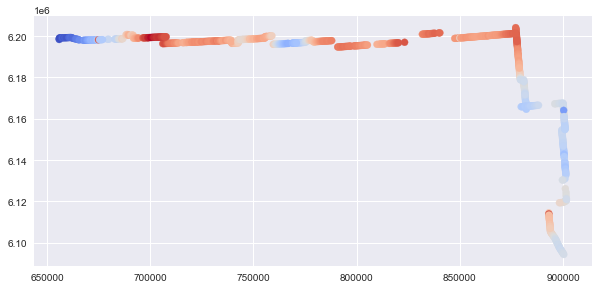

In [468]:
fig, ax = plt.subplots(figsize = (10, 10))
points_subset.plot(ax=ax, column='BOUGUER', cmap='coolwarm')
plt.show()